<a href="https://colab.research.google.com/github/michaelbarkasi/Intro_Cog_Sci_Examples/blob/main/Deep_Neural_Network_Sample_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network Sample - Sentiment Analysis

CC Michael Barkasi 2024

[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/) //
[BSD (3-Clause) License](https://opensource.org/licenses/BSD-3-Clause)

## Intro

What is this? Sample code and walkthrough of a neural network with hidden layers (a "deep" neural network). I put it together using the PyTorch library and some bits from the [Neuromatch Academy 2023 W1D5 tutorals](https://compneuro.neuromatch.io/tutorials/intro.html) on PyTorch, along with a good bit of help from ChatGPT. I checked and verified all code as best I could.

The network built and trained here will learn to classify highly polarized movie reviews based on word-token counts. We'll also explore ways of interpreting the hidden layer.

I wrote this CoLab so students could have first-hand experience with a deep neural network, and also see how easy it is to program one.

## The Data

This demo uses the [IMDb movie-review dataset curated by Andrew Maas](http://ai.stanford.edu/~amaas/data/sentiment/), from 2011. The dataset, as it's used here, contains 50k reviews split evenly into 25k for training, 25k for testing. It only contains highly poloarized reviews, i.e. reviews giving a rating of >= 7 stars or <= 4 stars. The data is preprocessed into an already-tokenized bag
of words (BoW).

## Sample Reviews from the Data Set

Sample Review A

Our family (and the entire sold out sneak preview audience) enjoyed "The Guardian". Kevin Costner and Ashton Kutcher gave convincing performances as the fictional helicopter rescue swimmer characters Ben and Jake. After seeing this movie, you can't help but imagine how difficult it must be to graduate from the USCG helicopter rescue swimmer school and one day take part in real rescues. Even though this is a fictional movie, it delivered rather convincing virtues of team spirit, dedication and bravery exhibited by all the members of the actual U. S. Coast Guard. The special effects used to create the rescue scenes were incredible. You actually felt like you were taking part in a real rescue. I feel the movie could have been made without the "Hollywood" bar scene (when you see the movie, you might agree) since the real Coast Guard does not condone such behavior. Very entertaining, very action packed, definitely worth seeing. Thank you, U. S. Coast Guard and the REAL helicopter rescue swimmers, "So Others May Live". I'd highly recommend this movie to everyone.

Sample Review B

This is a pale imitation of 'Officer and a Gentleman.' There is NO chemistry between Kutcher and the unknown woman who plays his love interest. The dialog is wooden, the situations hackneyed. It's too long and the climax is anti-climactic(!). I love the USCG, its men and women are fearless and tough. The action scenes are awesome, but this movie doesn't do much for recruiting, I fear. The script is formulaic, but confusing. Kutcher's character is trying to redeem himself for an accident that wasn't his fault? Costner's is raging against the dying of the light, but why? His 'conflict' with his wife is about as deep as a mud puddle. I saw this sneak preview for free and certainly felt I got my money's worth.

## Note

All code chunks must be run in order, so that all functions are defined and variables are properly initialized. I've used fixed random seeds, so it should be possible to rerun them selectively, once they've all been run the first time.

In [ ]:
# @title CoLab Reset
# Want to reset loaded code?
%reset -f

# Load Data and Structure Data

Let's start by loading the data. This may sound trivial or boring, but it's actually super important.

First, understanding how data is structured (and learning to structure it) is key to being able to use it, and key to understanding any piece of code working on it. A good place to start when approaching a piece of code or other algorithm is to understand how its inputs and outputs are structured. (This holds for the algorithms in the brain, too.)

Second, the format of the data (i.e., how it's structured) raises both philosophical and technical questions. In this case, we're trying to feed movie reviews into a neural network. This is a challenge, as the reviews are strings of English words, while the network can only take, as input, numbers. The data preprocessing from Maas _partly_ solves this challenge by simply assigning a number N to each word type, then counting the number M of times that word type appears (i.e., couting tokens) in a review. Each review than becomes a string of pairs of numbers with the form: N:M, e.g. 8:13 94:2 142:4.

How do we feed _that_ into a network? There are many ways, but we'll do it by making each word type a dimension in a vector space, and each review a point in that vector space. If there are k dimensions in that vector space (i.e., k word types in the data set), then the input layer of our network will have k units (i.e., neurons). Actually, we'll cut this number k down to 1000, throwing out most of the word types that aren't tokened often, and throwing out the 25 most frequent words (e.g., words like "the").

Now, we might ask, is this a _good_ way to format our data? Does it preserve interesting and important structure? Are the resulting numeric vectors good encodings ("representations") of the original reviews? Most importantly, will this encoding allow our network to learn to correctly classify reviews as positive or negative? Almost as important, will the hidden layer develop, through training, interesting structure of its own which reveals something about the data?

Let's find out!

In [ ]:
# @title Load Data and Libraries

# Import libraries
!pip install requests
import requests
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

# Fetch data
print("\nFetching data.")

url = 'https://raw.githubusercontent.com/michaelbarkasi/Intro_Cog_Sci_Examples/592c66c9609b39fe8843c899452a421dba194d2d/SampleDate_IMDbSentimentReviews/imdb.vocab'
feat_train_url = 'https://raw.githubusercontent.com/michaelbarkasi/Intro_Cog_Sci_Examples/592c66c9609b39fe8843c899452a421dba194d2d/SampleDate_IMDbSentimentReviews/labeledBow_train.feat'
feat_test_url = 'https://raw.githubusercontent.com/michaelbarkasi/Intro_Cog_Sci_Examples/592c66c9609b39fe8843c899452a421dba194d2d/SampleDate_IMDbSentimentReviews/labeledBow_test.feat'

response = requests.get(url)
response_feat_train = requests.get(feat_train_url)
response_feat_test = requests.get(feat_test_url)

# Initiate vocab list
vocab_list = []

# Check if the vocab request was successful
if response.status_code == 200:
    vocab_list = response.text.split('\n')  # Split the content into lines
    vocab_list = [word.strip() for word in vocab_list if word.strip()]  # Remove empty lines and strip whitespace
    print("Success! Fetched vocab file.")
else:
    print("Failed to fetch the vocab file.")

# Check if the train feat request was successful
if response_feat_train.status_code == 200:
    feat_train_lines = response_feat_train.text.split('\n')  # Split the content into lines
    feat_train_lines = [line.strip() for line in feat_train_lines if line.strip()]  # Remove empty lines and strip whitespace
    print("Success! Fetched training .feat file.")
else:
    print("Failed to fetch the training .feat file.")

# Check if the test feat request was successful
if response_feat_test.status_code == 200:
    feat_test_lines = response_feat_test.text.split('\n')  # Split the content into lines
    feat_test_lines = [line.strip() for line in feat_test_lines if line.strip()]  # Remove empty lines and strip whitespace
    print("Success! Fetched test .feat file.")
else:
    print("Failed to fetch the test .feat file.")



Fetching data.
Success! Fetched vocab file.
Success! Fetched training .feat file.
Success! Fetched test .feat file.


In [ ]:
# @title Structure and Examine Data

print("\nExamine Vocab list.")

# Check length of our vocab list
vocab_length = len(vocab_list)
print("Vocabulary List Length:", vocab_length)
print(f"First 10 words in list: {vocab_list[:10]}")
print(f"The 1,047th word in the list: {vocab_list[1047]}")

# Initiate numpy arrays which will hold our training and test data
'''
  Columns:
    There will be opening column for the review rating.
    There will also additional columns for each word in the vocab list.
  Rows:
    There will be one row for each line of the feat file, i.e. one row for each movie review
'''
num_columns = vocab_length + 1 # Add 1 for the rating column
train_data = np.zeros((len(feat_train_lines), num_columns), dtype=int)
test_data = np.zeros((len(feat_test_lines), num_columns), dtype=int)

# Fill in the data arrays based on the .feat file content
for i, line in enumerate(feat_train_lines):
    elements = line.split()
    train_data[i, 0] = int(elements[0])  # Rating (first column)
    for element in elements[1:]:
        word_index, token_count = element.split(':')
        train_data[i, int(word_index)+1] = int(token_count) # "+1" to make room for the rating column

for i, line in enumerate(feat_test_lines):
    elements = line.split()
    test_data[i, 0] = int(elements[0])  # Rating (first column)
    for element in elements[1:]:
        word_index, token_count = element.split(':')
        test_data[i, int(word_index)+1] = int(token_count) # "+1" to make room for the rating column

# Check resulting data arrays
print(f"\nTraining data array shape: {train_data.shape}")
print(f"Test data array shape: {test_data.shape}")

print("\nFirst 10x10 (rows/columns) of training data:")
print(train_data[:10,:10])

print("\nFirst 10x10 (rows/columns) of test data:")
print(test_data[:10,:10])

print("\nSample checking:")
check_review = 2
check_word = 3
print(f"Review {check_review} in the training data has {train_data[check_review,check_word+1]} tokens of word {check_word}, which is: {vocab_list[check_word]}\n")
print(f"Note: Indexing, e.g., for columns and rows, starts at zero in Python, so, look at the first matrix, fifth column from left, third line down, and you see 7.")



Examine Vocab list.
Vocabulary List Length: 89527
First 10 words in list: ['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']
The 1,047th word in the list: spirit

Training data array shape: (25000, 89528)
Test data array shape: (25000, 89528)

First 10x10 (rows/columns) of training data:
[[ 9  9  1  4  4  6  4  2  2  4]
 [ 7  7  4  2  2  0  4  1  0  2]
 [ 9  4  4  4  7  2  1  1  1  0]
 [10 10  2  2  0  3  2  4  2  0]
 [ 8 13  9  6  4  2  5 10  6  0]
 [10  6 11  4  5  3  1  2  6  7]
 [10  6  4  1  1  0  3  1  2  0]
 [ 7  3  3  6  1  3  2  0  2  5]
 [ 7  8  3  2  2  2  1  2  1  1]
 [ 7  9  7  8  3  4  5  3  0  0]]

First 10x10 (rows/columns) of test data:
[[10  7  4  2  5  5  1  3  1  6]
 [10  9  4  4  0  3  1 10  1 12]
 [ 7 21  7  4  5  7  8  0  5  8]
 [ 7 13  5  8  8  4  2  6  4  8]
 [10  4  1  2  1  3  2  3  2  4]
 [ 7  9  2  5  4  2  0  0  3  5]
 [ 7 10  6  4  4  4  1  1  0  3]
 [ 9 13  6  2  2  3  1  2  2  1]
 [ 9 17  6  5  8  2  0  2  7  2]
 [ 7 14  8  4  5  6  3  1  2


Hand-crafting a better input vector.

There are too many word types (89527);
 some are trivial words like 'the',
 while others don't have many tokens.

Excluding the 25 most frequent words.
Keeping the 1000 most frequent words after that.

Plots of word frequencies before cut-down:



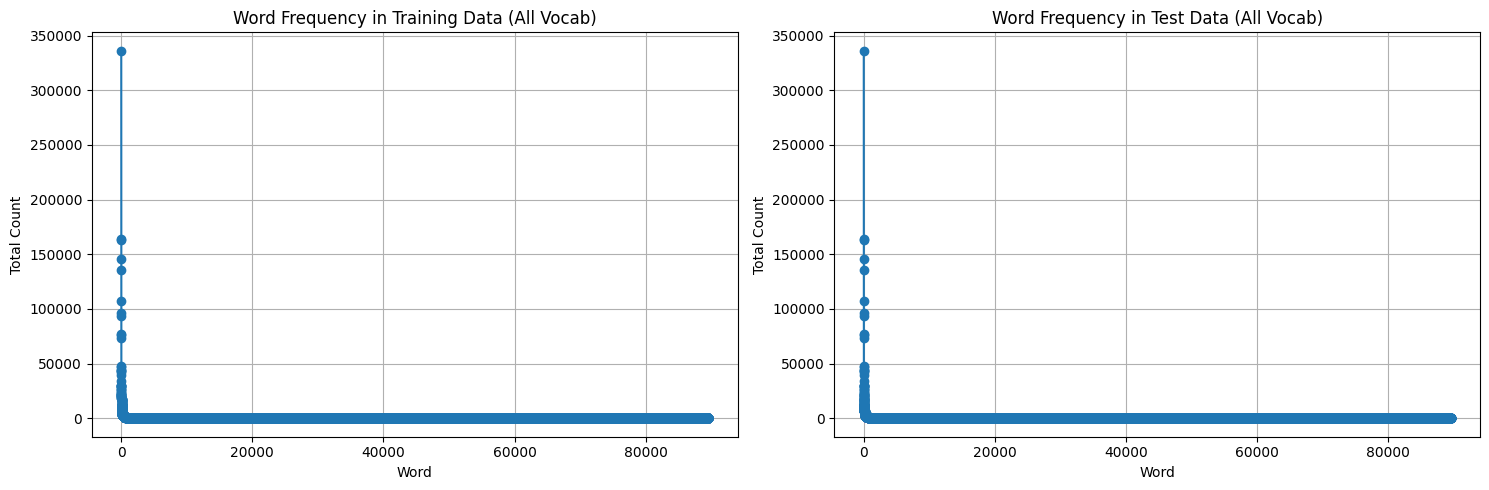


Plots of word frequencies after cut-down:



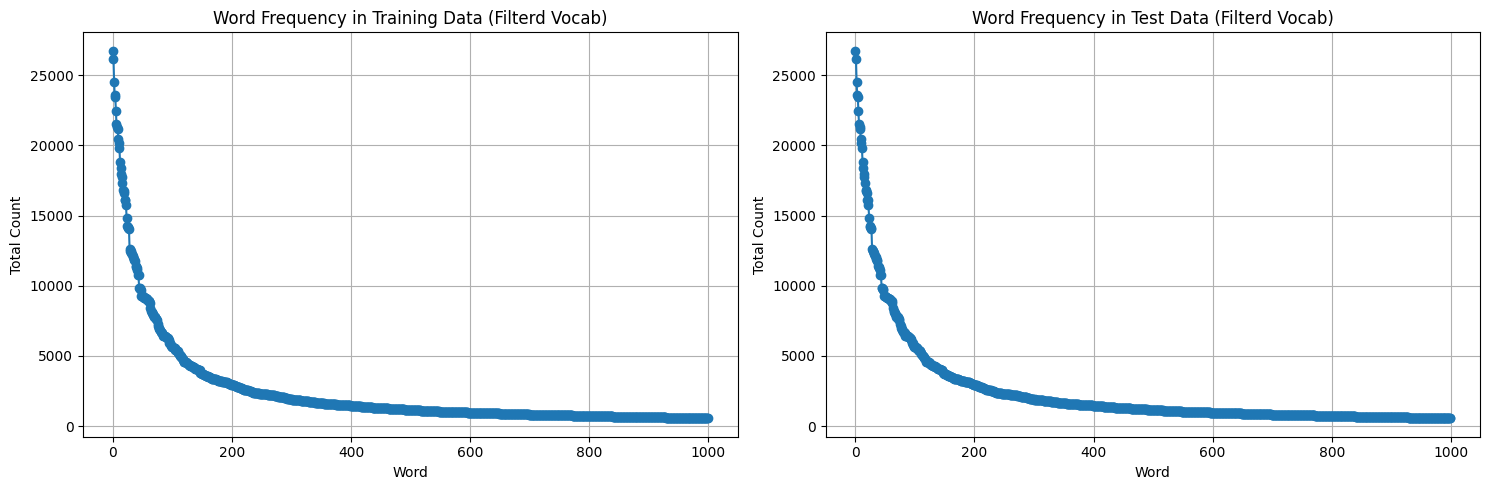


Results after removing unwanted word types:

Shape of train data: (25000, 1001)
Shape of test data: (25000, 1001)

The extra '1', i.e. '1001', is because one of the columns holds the ratings.



In [ ]:
# @title Hand-Crafted Feature Engineering

print(f"\nHand-crafting a better input vector.")

print(f"\nThere are too many word types ({vocab_length});\n some are trivial words like 'the',\n while others don't have many tokens.")

# How many features (of the most frequent?) to exclude (e.g., words like "and" and "or"), and how many of the next most frequent to keep?
exclude_most_frequent = 25
keep_next_most_frequent = 1000

print(f"\nExcluding the {exclude_most_frequent} most frequent words.")
print(f"Keeping the {keep_next_most_frequent} most frequent words after that.")

# Count word token frequencies
word_frequencies_train = np.sum(train_data, axis=0)
word_frequencies_test = np.sum(train_data, axis=0)

# Cut off first column, which holds the ratings
word_frequencies_train = word_frequencies_train[1:]
word_frequencies_test = word_frequencies_test[1:]

print(f"\nPlots of word frequencies before cut-down:\n")

# Plot word frequencies (token counts)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(word_frequencies_train, marker='o', linestyle='-')
ax1.set_xlabel('Word')
ax1.set_ylabel('Total Count')
ax1.set_title('Word Frequency in Training Data (All Vocab)')
ax1.grid(True)
ax2.plot(word_frequencies_test, marker='o', linestyle='-')
ax2.set_xlabel('Word')
ax2.set_ylabel('Total Count')
ax2.set_title('Word Frequency in Test Data (All Vocab)')
ax2.grid(True)
plt.tight_layout()
plt.show()

# Define function which will find and exclude the unwanted word types (columns)
def exclude_and_keep_n_largest(X, n, num_to_exclude, return_indices = False):
    # Find the indices of the largest num_to_exclude elements to exclude
    indices_to_exclude = np.argpartition(X, -num_to_exclude)[-num_to_exclude:]

    # Sort the remaining elements in ascending order
    remaining_indices = np.argpartition(X, -(n + num_to_exclude))[-(n + num_to_exclude):]

    # Remove the indices that were excluded
    remaining_indices = np.setdiff1d(remaining_indices, indices_to_exclude)

    # Create a new array containing the remaining n largest elements
    new_array = X[remaining_indices]

    if return_indices:
      return remaining_indices
    else:
      return new_array

# Run function to find the indices of those unwanted columns
indices_vocab_to_keep = exclude_and_keep_n_largest(X = word_frequencies_train,
                                                   n = keep_next_most_frequent,
                                                   num_to_exclude = exclude_most_frequent,
                                                   return_indices = True)

# Plot word frequences (token counts) of remaining word types
print(f"\nPlots of word frequencies after cut-down:\n")
word_frequencies_train = word_frequencies_train[indices_vocab_to_keep]
word_frequencies_test = word_frequencies_test[indices_vocab_to_keep]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(word_frequencies_train, marker='o', linestyle='-')
ax1.set_xlabel('Word')
ax1.set_ylabel('Total Count')
ax1.set_title('Word Frequency in Training Data (Filterd Vocab)')
ax1.grid(True)
ax2.plot(word_frequencies_test, marker='o', linestyle='-')
ax2.set_xlabel('Word')
ax2.set_ylabel('Total Count')
ax2.set_title('Word Frequency in Test Data (Filterd Vocab)')
ax2.grid(True)
plt.tight_layout()
plt.show()

# Add the cut-off first column (with ratings) back to the index vector
indices_vocab_to_keep = indices_vocab_to_keep + 1

# Cut down the train and test data arrays:
indices_vocab_to_keep = np.insert(indices_vocab_to_keep, 0, 0)
train_data = train_data[:, indices_vocab_to_keep]
test_data = test_data[:, indices_vocab_to_keep]

print("\nResults after removing unwanted word types:")
print(f"\nShape of train data: {train_data.shape}")
print(f"Shape of test data: {test_data.shape}")
print(f"\nThe extra '1', i.e. '{keep_next_most_frequent+1}', is because one of the columns holds the ratings.\n")

In [ ]:
# @title Create Torch Tensors for Training and Testing

'''
  We need to manipulate the data a little further,
  creating distinct inputs and outputs in a form PyTorch can use.
  We also might want to shuffle the rows of the arrays,
  as the original data has all the positive reviews first and all the negative reviews second.
  However, this crashes the free version of Colab with the full 25k reviews per test and train sets,
  so we'll only keep 5,000 reviews in each.
'''

print("\nPutting data in a format PyTorch can use, plus some other manipulations.")

rows_to_keep = 25000 # Keep all data
print(f"\nKeeping {rows_to_keep} reviews per test and train data sets.")
train_data = selected_rows = np.concatenate((train_data[:int(rows_to_keep/2)], train_data[12500:int(12500+(rows_to_keep/2))]))
test_data = selected_rows = np.concatenate((test_data[:int(rows_to_keep/2)], test_data[12500:int(12500+(rows_to_keep/2))]))

shuffle_data = True
if shuffle_data:
  print("\nShuffling rows of data arrays so positive and negative reviews are intermixed.")
  np.random.shuffle(train_data)
  np.random.shuffle(test_data)

print("\nCreating PyTorch tensors for inputs and outputs.")

train_y_raw = torch.from_numpy(train_data[:,0]) # This is the value we want to predict, i.e. the review rating
test_y_raw = torch.from_numpy(test_data[:,0])
train_X = torch.from_numpy(train_data[:,1:]) # This is the data from which we'll make the prediction, i.e. the word counts
test_X = torch.from_numpy(test_data[:,1:])

'''
  Printing shapes:
  Values should have the same number of rows as the reduced numpy arrays (rows_to_keep).
  The outputs should have 1 column.
  The intputs should have 1 less column than the numpy arrays (89,527).
'''

print(f"\nTraining input shape: {train_X.shape}")
print(f"Training output shape: {train_y_raw.shape}")

print(f"Test input shape: {test_X.shape}")
print(f"Test output shape: {test_y_raw.shape}")

# Convert outputs to 0/1 (positive, negative review) for binary classification.
print("\nThresholding raw outputs for binary classification.")

train_y = (train_y_raw >= 5).int()
test_y = (test_y_raw >= 5).int()

print(f"\nFirst 10 elements of raw training output: {train_y_raw[:10].tolist()}")
print(f"First 10 elements of thresholded training output: {train_y[:10].tolist()}\n")

# Convert all to floats
train_X = train_X.float()
train_y = train_y.float()
test_X = test_X.float()
test_y = test_y.float()



Putting data in a format PyTorch can use, plus some other manipulations.

Keeping 25000 reviews per test and train data sets.

Shuffling rows of data arrays so positive and negative reviews are intermixed.

Creating PyTorch tensors for inputs and outputs.

Training input shape: torch.Size([25000, 1000])
Training output shape: torch.Size([25000])
Test input shape: torch.Size([25000, 1000])
Test output shape: torch.Size([25000])

Thresholding raw outputs for binary classification.

First 10 elements of raw training output: [1, 10, 10, 10, 3, 10, 1, 7, 3, 1]
First 10 elements of thresholded training output: [0, 1, 1, 1, 0, 1, 0, 1, 0, 0]



# Setup Neural Network

With our data formated and ready to go, we have to set up the network that will learn that data. We will keep it as basic as possible.

1. The network will have three layers: input, a single hidden layer, and an output layer. I tried multiple hidden layers, without notably different results.
2. The layers will be fully connected and feedforward.
3. The input layer will have 1000 units, for the 1000 word types we saved in the data.
4. The hidden layer will have 50 units. Why? It seemed like a good number. I tried some other sizes (e.g., 10 and 200), without notably different results.
5. The output layer will have 1 unit, trained to hit "1" for positive reviews and "0" for negative reviews.
6. The hidden units will be put through a Rectified Linear Unit (ReLU) activation function.
7. The output unit will be put through a sigmoid activation function.

Here is a schematic diagram. Obviously, not all units are shown in the input and hidden layers.

<div>
<img src="https://drive.google.com/uc?export=view&id=1hz_YA0JY4Pmrs3eedKEmwXAetoBKmaZ_" alt="Schematic Figure of the Neural Network we'll Build" width="500"/>
</div>


Defining deep neural network (making a binary classifer).

Setting the number of units.

Input units: 1000
Hidden units: 50 (ReLU)
Output units: 1 (Sigmoid)

Initializing network as 'net'.

As a demonstration, computing output (ratings) via the input data (word token counts) and the randomized initial weights.

... Plotting.



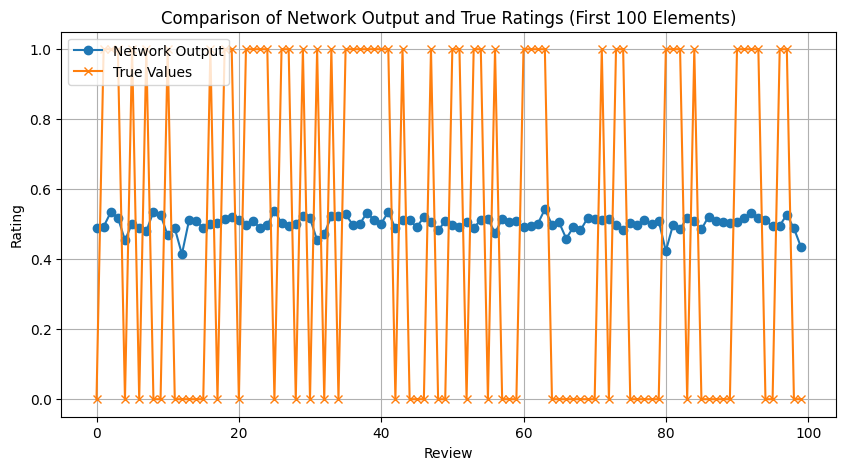


As you can see, the network is no good at predicting the ratings! We will need to train it.



In [ ]:
# @title Initiate Neural Network

print(f"\nDefining deep neural network (making a binary classifer).")
class BinaryClassifier(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        super(BinaryClassifier, self).__init__()
        self.in_layer = nn.Linear(n_inputs, n_hidden)
        self.out_layer = nn.Linear(n_hidden, 1)

    def forward(self, r):
        h = torch.relu(self.in_layer(r))
        y = torch.sigmoid(self.out_layer(h))
        return y

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Set number of input units
print(f"\nSetting the number of units.")
n_neurons = train_X.shape[1]
num_of_hidden_units = 50
print(f"\nInput units: {n_neurons}")
print(f"Hidden units: {num_of_hidden_units} (ReLU)")
print(f"Output units: {1} (Sigmoid)")

# Initialize a deep network with hidden units
print(f"\nInitializing network as 'net'.")
net = BinaryClassifier(n_neurons, num_of_hidden_units)

# Estimate ratings from review text using initialized network
print(f"\nAs a demonstration, computing output (ratings) via the input data (word token counts) and the randomized initial weights.")
out_y = net(train_X)  # compute output from network, equivalent to net.forward(r)

# Plot results against the true ratings
# Convert Torch tensors to NumPy arrays for plotting
output_array = out_y.detach().numpy()
true_values_array = train_y.detach().numpy()

# Plot the first 100 elements
print(f"\n... Plotting.\n")
plt.figure(figsize=(10, 5))
plt.plot(output_array[:100], label='Network Output', marker='o', linestyle='-')
plt.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
plt.xlabel('Review')
plt.ylabel('Rating')
plt.title('Comparison of Network Output and True Ratings (First 100 Elements)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nAs you can see, the network is no good at predicting the ratings! We will need to train it.\n")

# Train Network

We will now use gradient descent to train our network. We have divided our data (50k reviews) into two batches of 25k reviews: a training set, and a test set. We will train on the training set, then later test the network's accuracy on the test set. If the network has larger accuracy on the training set than the test set, we know that it's overfitting (i.e., learning noise in the data, and not true underlying statistical patterns).


Using gradient descent to train network.

Defining function which will run gradient descent for a specificed number of iterations ('epochs').

Selecting binary cross-entropy loss as loss (error) function to minimize.

Number of epochs to train: 1000
Learning rate: 0.05

... training!

iteration 1/1000 | loss: 0.695
iteration 100/1000 | loss: 0.561
iteration 200/1000 | loss: 0.452
iteration 300/1000 | loss: 0.402
iteration 400/1000 | loss: 0.373
iteration 500/1000 | loss: 0.353
iteration 600/1000 | loss: 0.339
iteration 700/1000 | loss: 0.329
iteration 800/1000 | loss: 0.322
iteration 900/1000 | loss: 0.316
iteration 1000/1000 | loss: 0.312




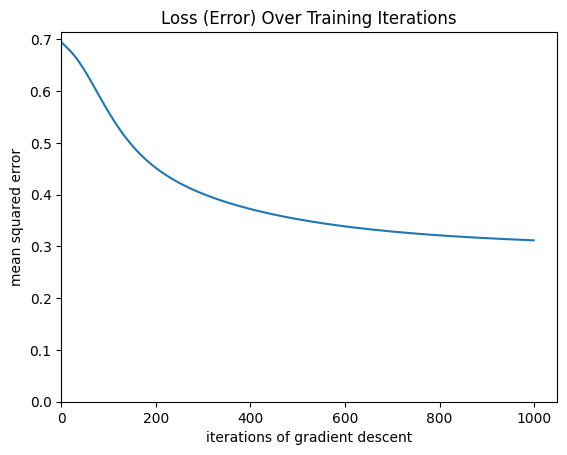


Complete!



In [ ]:
# @title Use Gradient Descent to Train Network

print("\nUsing gradient descent to train network.")
print(f"\nDefining function which will run gradient descent for a specificed number of iterations ('epochs').")

def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):

  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): 2D PyTorch tensor with the training input data
    train_labels (torch.Tensor): 1D PyTorch tensor the intended outputs we want the network to learn
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # Clear previous gradients
    optimizer.zero_grad()

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_epochs // 10) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')
    elif i == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Use Binary Cross-Entropy Loss
print("\nSelecting binary cross-entropy loss as loss (error) function to minimize.")
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

epochs_to_train = 1000
learning_rate_to_use = 0.05

print(f"\nNumber of epochs to train: {epochs_to_train}")
print(f"Learning rate: {learning_rate_to_use}")

print("\n... training!\n")

# Run gradient descent on data
train_y = train_y.view(-1, 1) # fix dimensionality of labels
train_loss = train(net, loss_fn, train_X, train_y,
          n_epochs=epochs_to_train, learning_rate=learning_rate_to_use)

# Plot the training loss over iterations of GD
def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.title('Loss (Error) Over Training Iterations')
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()

print("\n")
plot_train_loss(train_loss)

print("\nComplete!\n")

## Saving and loading network parameters

By default these are set to not run, but desired, you can save the network parameters that were just learned, or load them from when I ran the code last.

In [ ]:
# @title Export Model

export_model = False

if export_model:

  # Save the model's state dictionary to a file
  torch.save(net.state_dict(), 'model_weights.pth')

  from google.colab import files

  # Provide the file path of the saved model weights
  file_path = 'model_weights.pth'

  # Export the file to your local drive
  files.download(file_path)

In [ ]:
# @title Load Previously Trained Parameters

import io

load_model = False

if load_model:

  raw_github_url = 'https://raw.githubusercontent.com/michaelbarkasi/Intro_Cog_Sci_Examples/e835d01f4d33dd4cb6b0dbd08178b0948c1ef746/model_weights.pth'
  response = requests.get(raw_github_url)

  # Check if the download was successful
  if response.status_code == 200:
      # Create a file-like object from the content
      file_content = response.content
      # Load the model weights from the file content
      loaded_state_dict = torch.load(io.BytesIO(file_content), map_location=torch.device('cpu'))
      # Load the state_dict
      net.load_state_dict(loaded_state_dict)
      # Put the model in evaluation mode if needed
      net.eval()
      print("\nSuccess! Loaded model parameters from previous training.")
  else:
      print("\nFailed to download the file from GitHub.")



# Quantify Network Performance

Hurrah! The network is trained, with an end loss (error) of 0.312. What, exactly, does that mean? It doesn't really matter. What matters is the network's accuracy at predicing the sentiment (positive or negative) of a review.

So, next we'll quantify (as a percentage) how often the network correctly predicts whether a review is positive or negative. We'll do this for both the reviews in the training data (because why not?), and (more importantly) for the reviews in the test data. We care not only about the absolute percentages, but how the two compare. If the network is notably more accurate on the training data than the test data, that tells us that it "overfit" the training data. A network is overfit when it learns to use ideosyncratic noise in the training data instead of relying only on true underlying statistical patterns (patterns which should hold in the test data). We want our network to _generalize_, i.e., do well on new data it hasn't seen in training.

As you'll see, the network output is from the sigmoid activation function. It's a continuous real number between 1 and 0, not a binary response of 1 or 0. We'll plot the raw real number response below. However, to quantify the final network performance, we'll pass its raw output through one more layer of thresholding that sets the output to 1 if it's >= 0.5 and sets its output to 0 otherwise.


Running reviews from test data through the trained network to generate its predictions of sentiment (ratings).

Running raw sigmoid output through a binary threshold of 0.5 to produce a binary classification.

Percentage correct before trianing (Training Data): 49.44%
Percentage correct after training (Training Data): 87.58%

Plots:



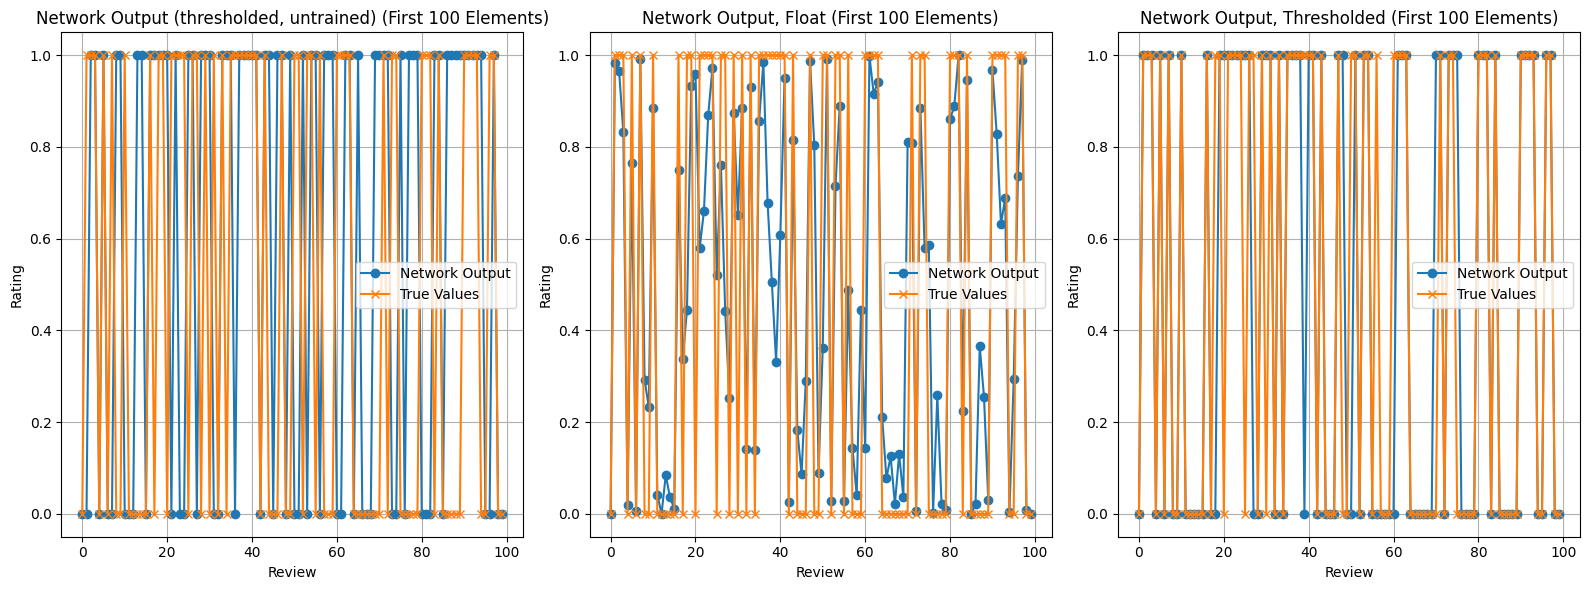

In [ ]:
# @title Final Performance on Training Data

# Estimate ratings from review text using initialized network
print(f"\nRunning reviews from test data through the trained network to generate its predictions of sentiment (ratings).")
out_y_new = net(train_X)  # compute output from network, equivalent to net.forward(r)

# Pass output through a binary cuttoff (threshold):
print(f"\nRunning raw sigmoid output through a binary threshold of 0.5 to produce a binary classification.")
out_y_new_threshold = (out_y_new >= 0.5).int()

# Plot results against the true ratings
# Convert Torch tensors to NumPy arrays for plotting
output_array = out_y_new.detach().numpy()
output_threshold_array = out_y_new_threshold.detach().numpy()
true_values_array = train_y.detach().numpy()
# Find thresholded accuracy percentage, before training
out_y_threshold = (out_y >= 0.5).int()
output_threshold_array_old = out_y_threshold.detach().numpy()
true_values_array = true_values_array.reshape(output_threshold_array_old.shape)
matching_elements_old = (output_threshold_array_old == true_values_array)
percent_matching_old = (np.sum(matching_elements_old) / len(output_threshold_array_old)) * 100.0
print(f"\nPercentage correct before trianing (Training Data): {percent_matching_old:.2f}%")
# Find thresholded accuracy percentage, after training
true_values_array = true_values_array.reshape(output_threshold_array.shape)
matching_elements = (output_threshold_array == true_values_array)
percent_matching = (np.sum(matching_elements) / len(output_threshold_array)) * 100.0
print(f"Percentage correct after training (Training Data): {percent_matching:.2f}%")
print("\nPlots:\n")

# Create a figure with one row and three columns for subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))  # Adjust figsize as needed
# Plot the first 100 elements, thresholded output (untrained)
ax1.plot(output_threshold_array_old[:100], label='Network Output', marker='o', linestyle='-')
ax1.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax1.set_xlabel('Review')
ax1.set_ylabel('Rating')
ax1.set_title('Network Output (thresholded, untrained) (First 100 Elements)')
ax1.legend()
ax1.grid(True)
# Plot the first 100 elements, raw float output
ax2.plot(output_array[:100], label='Network Output', marker='o', linestyle='-')
ax2.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax2.set_xlabel('Review')
ax2.set_ylabel('Rating')
ax2.set_title('Network Output, Float (First 100 Elements)')
ax2.legend()
ax2.grid(True)
# Plot the first 100 elements, thresholded output
ax3.plot(output_threshold_array[:100], label='Network Output', marker='o', linestyle='-')
ax3.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax3.set_xlabel('Review')
ax3.set_ylabel('Rating')
ax3.set_title('Network Output, Thresholded (First 100 Elements)')
ax3.legend()
ax3.grid(True)
# Adjust spacing between subplots
plt.tight_layout()
# Show the combined plot
plt.show()

print("\n")


Running reviews from test data through the trained network to generate its predictions of sentiment (ratings).

Running raw sigmoid output through a binary threshold of 0.5 to produce a binary classification.

Percentage correct after training (Test Data): 86.18%

Plots:



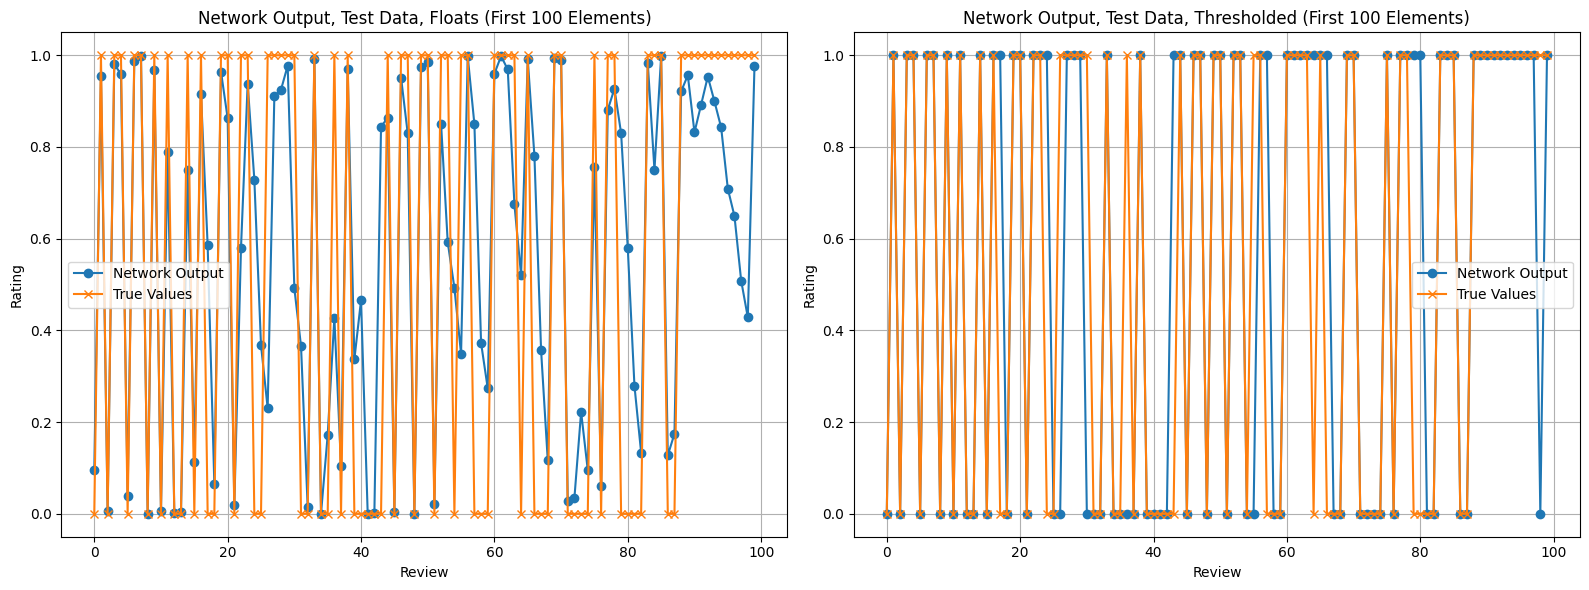

In [ ]:
# @title Performance on Test Data

# Estimate ratings from review text using initialized network
print(f"\nRunning reviews from test data through the trained network to generate its predictions of sentiment (ratings).")
out_y_new = net(test_X)  # compute output from network, equivalent to net.forward(r)

# Pass output through a binary cuttoff (threshold):
print(f"\nRunning raw sigmoid output through a binary threshold of 0.5 to produce a binary classification.")
out_y_new_threshold = (out_y_new >= 0.5).int()

# Plot results against the true ratings
# Convert Torch tensors to NumPy arrays for plotting
output_array = out_y_new.detach().numpy()
output_threshold_array = out_y_new_threshold.detach().numpy()
true_values_array = test_y.detach().numpy()

# Find thresholded accuracy percentage, after training
true_values_array = true_values_array.reshape(output_threshold_array.shape)
matching_elements = (output_threshold_array == true_values_array)
percent_matching = (np.sum(matching_elements) / len(output_threshold_array)) * 100.0
print(f"\nPercentage correct after training (Test Data): {percent_matching:.2f}%")
print("\nPlots:\n")

# Create a figure with one row and three columns for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed
# Plot the first 100 elements, test data, raw float output
ax1.plot(output_array[:100], label='Network Output', marker='o', linestyle='-')
ax1.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax1.set_xlabel('Review')
ax1.set_ylabel('Rating')
ax1.set_title('Network Output, Test Data, Floats (First 100 Elements)')
ax1.legend()
ax1.grid(True)
# Plot the first 100 elements, thresholded output
ax2.plot(output_threshold_array[:100], label='Network Output', marker='o', linestyle='-')
ax2.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax2.set_xlabel('Review')
ax2.set_ylabel('Rating')
ax2.set_title('Network Output, Test Data, Thresholded (First 100 Elements)')
ax2.legend()
ax2.grid(True)
# Adjust spacing between subplots
plt.tight_layout()
# Show the combined plot
plt.show()

print("\n")

## Results

The fully trained network has an accuracy of 87.58% on the training data, and 86.18% on the test data. That's pretty good! It suggests the network hasn't overfitted to the training data.

It would, of course, be nice the network was a bit more accurate. There are lots of ways we could perhaps improve it, but, such for a bare-bones network with a very crude encoding of the reviews (by word token counts), 86% accuracy is perhaps not too bad.

# Analyze Network Weights and the Network's Uniterpretability

The network we've built and trained does a reasonable job predicting the sentiment (positive or negative) of the IMBd reviews. How, exactly, is it making this prediction?

To answer this question, we're going to examine the weights in the network. In essence, we're going to extract the "tuning curves" of the hidden layer units, to see which input "features" they respond to best.

In essence, what we will do is examine the weights of the hidden and input units, finding those hidden units which highly excite or highly inhibit the output unit. Then, we'll look at which input units have weights such that they highly excite or highly inhibit those strong hidden units, and (finally) we'll examine which word types are encoded by those input units. Schematically:

<div>
<img src="https://drive.google.com/uc?export=view&id=1nyoCDZkLhhjl9bgNYweGusgAn2KEQQwV" alt="Schematic Figure of Neuron" width="500"/>
</div>


There are 50 units in the hidden layer. Let's plot the weights of their connections to the output unit.



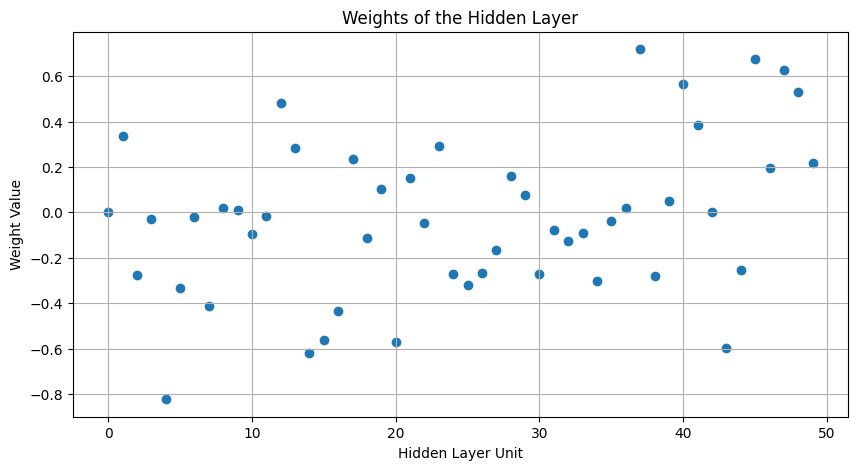


Let's grab the indices for hidden units with especially strong (excitatory or inhibitory) weights.

Indices where elements > 0.4 (strong excitation): [12 37 40 45 47 48]
Indices where elements < -0.4 (strong inhibition): [ 4  7 14 15 16 20 43]


In [ ]:
# @title Analyze Hidden Layer Weights

print(f"\nThere are {num_of_hidden_units} units in the hidden layer. Let's plot the weights of their connections to the output unit.\n")

significance_cutoff = 0.4

# Access the weight matrix of the hidden layer
hidden_layer_weights = net.out_layer.weight.data.numpy()  # Assuming it's a PyTorch model

# Create scatter plot for the weights
plt.figure(figsize=(10, 5))
plt.scatter(range(hidden_layer_weights.shape[1]), hidden_layer_weights[0,:])
plt.title('Weights of the Hidden Layer')
plt.xlabel('Hidden Layer Unit')
plt.ylabel('Weight Value')
plt.grid(True)
plt.show()

# Find the strongest (excitator or inhibatory) weights:
weights = hidden_layer_weights[0, :]

# Find indices where elements are greater than 0.3
large_excitation = np.where(weights > significance_cutoff)[0]

# Find indices where elements are less than 0.3
large_inhibition = np.where(weights < -significance_cutoff)[0]

print("\nLet's grab the indices for hidden units with especially strong (excitatory or inhibitory) weights.")

print(f"\nIndices where elements > {significance_cutoff} (strong excitation):", large_excitation)
print(f"Indices where elements < {-significance_cutoff} (strong inhibition):", large_inhibition)



Now let's take those strong excitation and strong inhibition hidden
 units and analyze the input units which have strong connection weights to these hidden units.

Trimming vocab list.

For each of the identified hidden units, we'll identify the 5
 strongest excitatory and inhibatory inputs.

We will then look up the word types represented by those input units.

For example, the five top excitatory inputs for the 12th hidden unit, which itself is excitatory,
 are: ['fantastic' 'favorite' 'amazing' 'wonderful' 'perfect']

This means that a high number of tokens of these words in a review cause a strong positive response
 from hidden unit 12, which in turn causes a strong positive response in the output unit.

Results:

Strongest 5 inputs for the strongest (>0.4) excitatory hidden units:

Top Excitatory Inputs, Excitatory Unit Number 12:
['fantastic' 'favorite' 'amazing' 'wonderful' 'perfect']

Top Inhibitory Inputs, Excitatory Unit Number 12:
['worst' 'awful' 'boring' 'unfortunately' '

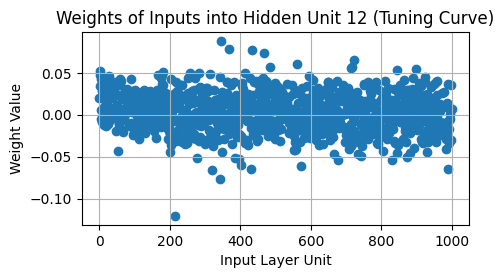


Top Excitatory Inputs, Excitatory Unit Number 37:
['loved' 'perfect' 'wonderful' 'excellent' 'great']

Top Inhibitory Inputs, Excitatory Unit Number 37:
['worst' 'waste' 'poorly' 'poor' 'terrible']




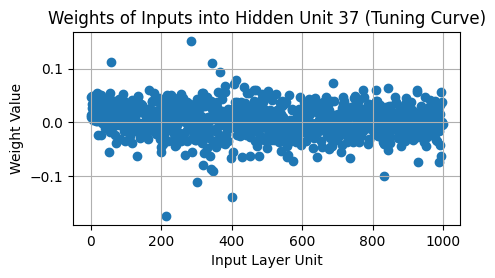


Top Excitatory Inputs, Excitatory Unit Number 40:
['great' 'fun' 'highly' 'excellent' 'wonderful']

Top Inhibitory Inputs, Excitatory Unit Number 40:
['worst' 'awful' 'waste' 'horrible' 'worse']




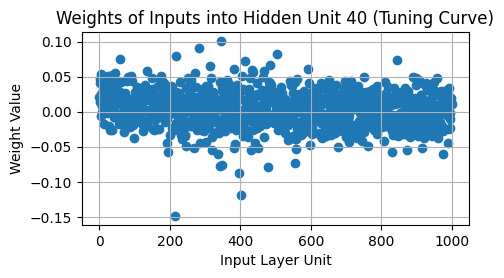


Top Excitatory Inputs, Excitatory Unit Number 45:
['fantastic' 'today' 'great' 'wonderful' 'excellent']

Top Inhibitory Inputs, Excitatory Unit Number 45:
['worst' 'poor' 'waste' 'awful' 'boring']




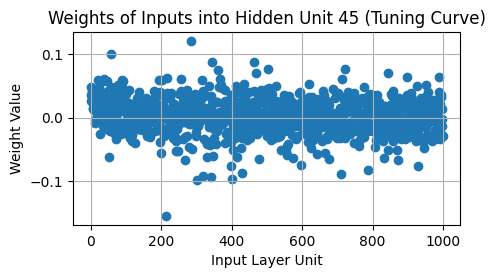


Top Excitatory Inputs, Excitatory Unit Number 47:
['perfect' 'enjoyed' 'wonderful' 'loved' 'excellent']

Top Inhibitory Inputs, Excitatory Unit Number 47:
['waste' 'awful' 'worse' 'worst' 'unfortunately']




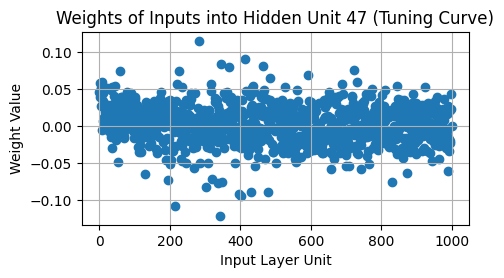


Top Excitatory Inputs, Excitatory Unit Number 48:
['enjoy' 'perfect' 'today' 'great' 'amazing']

Top Inhibitory Inputs, Excitatory Unit Number 48:
['waste' 'annoying' 'worst' 'awful' 'boring']




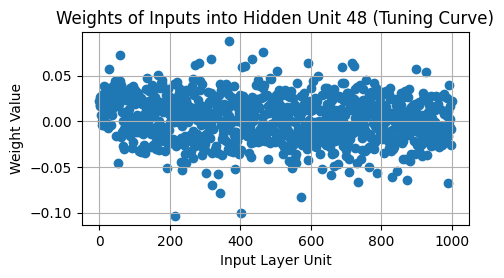


Strongest 5 inputs for the strongest (<-0.4) inhibitory hidden units:

Top Excitatory Inputs, Inhibitory Unit Number 4:
['unfortunately' 'worse' 'worst' 'waste' 'awful']

Top Inhibitory Inputs, Inhibitory Unit Number 4:
['excellent' 'today' 'perfect' 'wonderful' 'enjoyed']




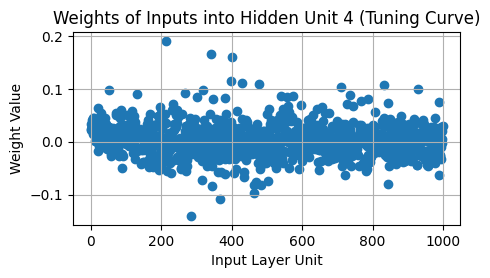


Top Excitatory Inputs, Inhibitory Unit Number 7:
['instead' 'terrible' 'worst' 'boring' 'poor']

Top Inhibitory Inputs, Inhibitory Unit Number 7:
['excellent' 'amazing' 'perfect' 'wonderful' 'favorite']




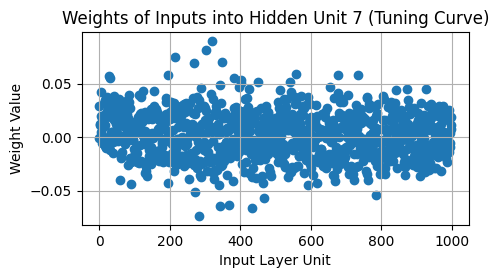


Top Excitatory Inputs, Inhibitory Unit Number 14:
['waste' 'poor' 'bad' 'horrible' 'worst']

Top Inhibitory Inputs, Inhibitory Unit Number 14:
['excellent' 'wonderful' 'amazing' 'easy' 'favorite']




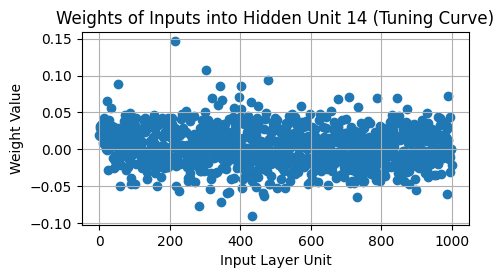


Top Excitatory Inputs, Inhibitory Unit Number 15:
['poorly' 'waste' 'awful' 'boring' 'worst']

Top Inhibitory Inputs, Inhibitory Unit Number 15:
['wonderful' 'perfect' 'highly' 'fun' 'excellent']




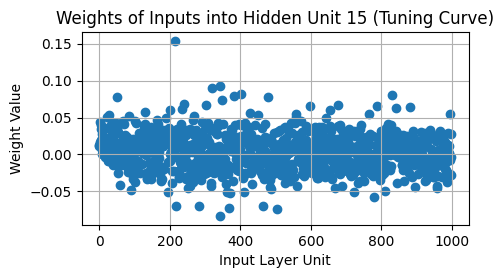


Top Excitatory Inputs, Inhibitory Unit Number 16:
['worse' 'avoid' 'awful' 'worst' 'waste']

Top Inhibitory Inputs, Inhibitory Unit Number 16:
['perfect' 'excellent' 'superb' 'amazing' 'beautiful']




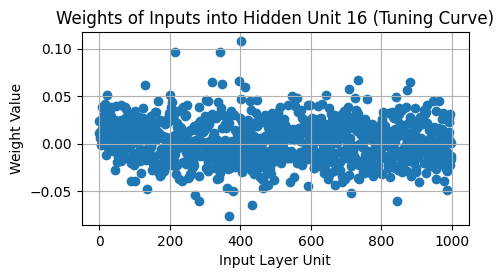


Top Excitatory Inputs, Inhibitory Unit Number 20:
['terrible' 'boring' 'awful' 'worst' 'waste']

Top Inhibitory Inputs, Inhibitory Unit Number 20:
['enjoyed' 'amazing' 'definitely' 'superb' 'moving']




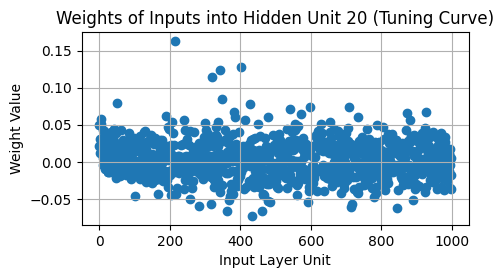


Top Excitatory Inputs, Inhibitory Unit Number 43:
['terrible' 'poor' 'worst' 'waste' 'boring']

Top Inhibitory Inputs, Inhibitory Unit Number 43:
['loved' 'excellent' 'superb' 'favorite' 'brilliant']




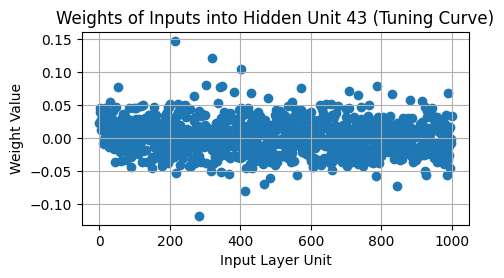

In [ ]:
# @title Analyze Input Layer Weights into Strongest Hidden Layer Units

print("\nNow let's take those strong excitation and strong inhibition hidden\n units and analyze the input units which have strong connection weights to these hidden units.")

# Update vocab list
if len(vocab_list) > len(indices_vocab_to_keep):
  print("\nTrimming vocab list.")
  indices_vocab_to_keep = indices_vocab_to_keep[1:] - 1
  vocab_list = np.take(vocab_list,indices_vocab_to_keep)

# Define the number of top input units to retrieve
num_top_inputs = 5

# Create a new array for storing a version of the test input data without strong generic valence terms
test_X_pruned = np.copy(test_X)

print(f"\nFor each of the identified hidden units, we'll identify the {num_top_inputs}\n strongest excitatory and inhibatory inputs.")
print("\nWe will then look up the word types represented by those input units.")
print("\nFor example, the five top excitatory inputs for the 12th hidden unit, which itself is excitatory,\n are: ['fantastic' 'favorite' 'amazing' 'wonderful' 'perfect']")
print("\nThis means that a high number of tokens of these words in a review cause a strong positive response\n from hidden unit 12, which in turn causes a strong positive response in the output unit.")

print("\nResults:")

# Grab weight matrix of the input to hidden layer
input_layer_weights = net.in_layer.weight.data.numpy()  # Assuming it's a PyTorch model

# Loop through the indices of large_excitation
print(f"\nStrongest {num_top_inputs} inputs for the strongest (>{significance_cutoff}) excitatory hidden units:")
for hidden_unit_index in large_excitation:

    # Get the weights for the specified hidden unit
    input_unit_weights = input_layer_weights[hidden_unit_index]

    # Get the indices of the top input units with the largest absolute weights
    top_indices = np.argpartition(input_unit_weights, -num_top_inputs)[-num_top_inputs:]
    test_X_pruned[:,top_indices] = 0 # Set to zero in this new data array to removed these terms

    # These indices should now correspond to indices in our vocab list
    print(f"\nTop Excitatory Inputs, Excitatory Unit Number {hidden_unit_index}:")
    print(np.take(vocab_list,top_indices)) # Unclear why np.take is needed, and why vocab_list[top_indices] won't work

    # Get the indices of the top input units with the smallest weights
    bottom_indices = np.argpartition(input_unit_weights, num_top_inputs)[:num_top_inputs]
    test_X_pruned[:,bottom_indices] = 0 # Set to zero in this new data array to removed these terms

    # These indices should now correspond to indices in our vocab list
    print(f"\nTop Inhibitory Inputs, Excitatory Unit Number {hidden_unit_index}:")
    print(np.take(vocab_list, bottom_indices))

    # Create scatter plot for the weights (tuning curve)
    print("\n")
    plt.figure(figsize=(5, 2.5))
    plt.scatter(np.arange(input_unit_weights.shape[0]), input_unit_weights)
    plt.title(f'Weights of Inputs into Hidden Unit {hidden_unit_index} (Tuning Curve)')
    plt.xlabel('Input Layer Unit')
    plt.ylabel('Weight Value')
    plt.grid(True)
    plt.show()

# Loop through the indices of large_inhibition
print(f"\nStrongest {num_top_inputs} inputs for the strongest (<{-significance_cutoff}) inhibitory hidden units:")
for hidden_unit_index in large_inhibition:

    # Get the weights for the specified hidden unit
    input_unit_weights = input_layer_weights[hidden_unit_index]

    # Get the indices of the top input units with the largest absolute weights
    top_indices = np.argpartition(input_unit_weights, -num_top_inputs)[-num_top_inputs:]
    test_X_pruned[:,top_indices] = 0 # Set to zero in this new data array to removed these terms

    # These indices should now correspond to indices in our vocab list
    print(f"\nTop Excitatory Inputs, Inhibitory Unit Number {hidden_unit_index}:")
    print(np.take(vocab_list,top_indices)) # Unclear why np.take is needed, and why vocab_list[top_indices] won't work

    # Get the indices of the top input units with the smallest weights
    bottom_indices = np.argpartition(input_unit_weights, num_top_inputs)[:num_top_inputs]
    test_X_pruned[:,bottom_indices] = 0 # Set to zero in this new data array to removed these terms

    # These indices should now correspond to indices in our vocab list
    print(f"\nTop Inhibitory Inputs, Inhibitory Unit Number {hidden_unit_index}:")
    print(np.take(vocab_list, bottom_indices))

    # Create scatter plot for the weights (tuning curve)
    print("\n")
    plt.figure(figsize=(5, 2.5))
    plt.scatter(np.arange(input_unit_weights.shape[0]), input_unit_weights)
    plt.title(f'Weights of Inputs into Hidden Unit {hidden_unit_index} (Tuning Curve)')
    plt.xlabel('Input Layer Unit')
    plt.ylabel('Weight Value')
    plt.grid(True)
    plt.show()

# Convert new test data into Torch Tensor
test_X_pruned = torch.from_numpy(test_X_pruned)

## Discussion

For each of the hidden units which cause a strong positive response in the network output, here are the five words which cause the strongest response:

['fantastic' 'favorite' 'amazing' 'wonderful' 'perfect']

['loved' 'perfect' 'wonderful' 'excellent' 'great']

['great' 'fun' 'highly' 'excellent' 'wonderful']

['fantastic' 'today' 'great' 'wonderful' 'excellent']

['perfect' 'enjoyed' 'wonderful' 'loved' 'excellent']

['enjoy' 'perfect' 'today' 'great' 'amazing']

As can be seen, almost all of these words are close synonyms. Further, there is a good bit of overlap between the lists. For example, "wonderful" appears in five of the six lists.

What this list tells us is that these six hidden units are not learning _different_ concepts which each signal a positive view. For example, it's not as if one of the units is responsive to words related to good acting, while another is responsive to words related to a good music score. Instead, all six hidden units respond most strongly to generic positive words, e.g. "great", "wonderful", "excellent".

A similar pattern holds for the words which inhibit these excitatory hidden units (those words are all generic negative words), and the pattern holds in reverse for the inhibatory hidden units (generic positive words inhibit them, while generic negative words excite them).

## Hidden Subtlety?

Now, there might be more subtlety to our hidden units, subtlety which this analysis hasn't brought out. There are different ways we could test for this subtlety. For example, we could remove all of these strongly valenced, but generic, words from the reviews and see how the network performed classifying the edited reviews. If it still performs above chance, that would indicate that it's using additional information beyond generic valence terms like "awful" and "great". Conversely, we could remove all the words _but_ these generic valence terms and see if the network does worse with its predictions.

The former approach is run in the code chunk below. As can be seen, even with the top five strong generic valence terms removed from the taken, the network still has an accuracy of 81.36% on the test data! That's not too far off from the 86.18% the network performed with those terms. While there might still be remaining strong generic valence terms helping the network, this kind of result shows that the network is indeed doing more than just predicting that reviews with the word "great" are positive and reviews with the word "awful" are negative.

## Black Boxes and Uniterpretability

What, exactly, is the network doing? How does it work? That's just unclear. We could probe more, doing more and more analysis as I've begun here. That would help clarify the picture, but even with a very small network like this one, there's no guarentee that we'd come out with a rigorous or clear picture of how it's making its decisions.



Running reviews, without strong valence terms, from test data through the trained network to generate its predictions of sentiment (ratings).

Running raw sigmoid output through a binary threshold of 0.5 to produce a binary classification.

Percentage correct after training (Test Data, strong valence terms removed): 81.36%

Plots:



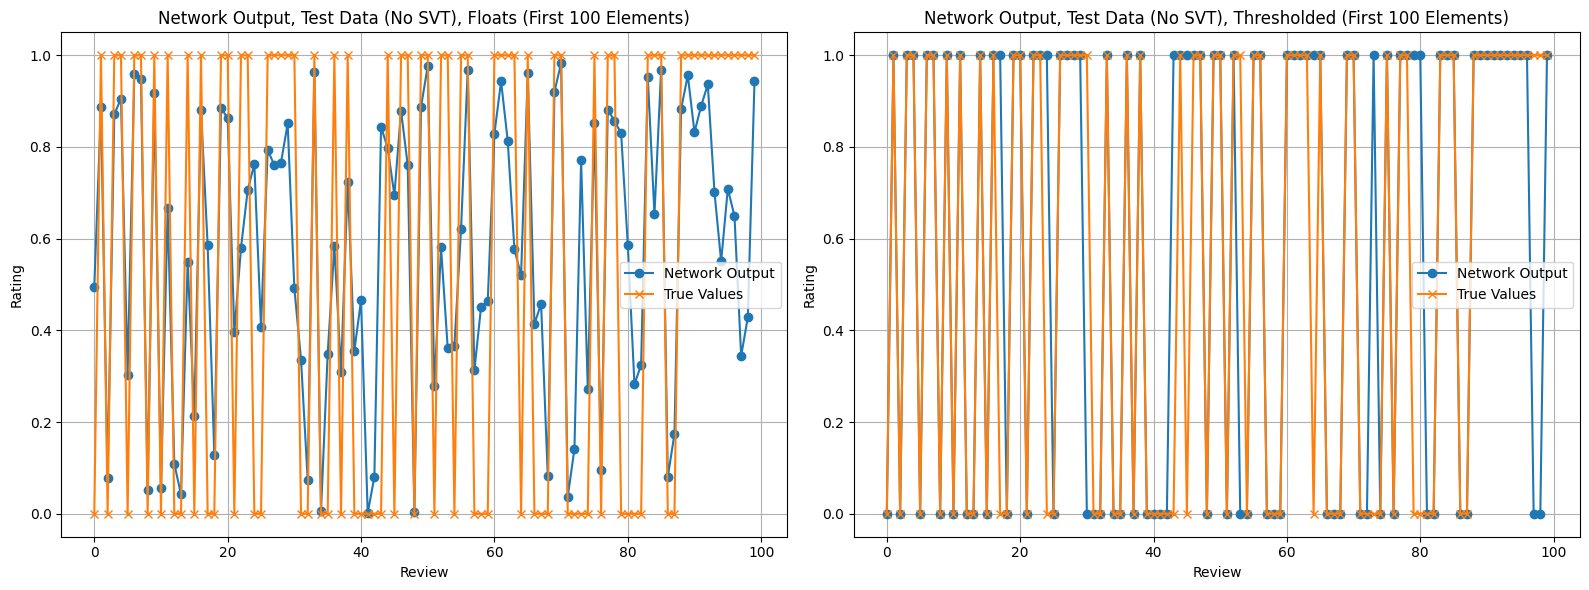

In [ ]:
# @title Performance on Test Data with Strong Valence Terms Removed

# Estimate ratings from review text using initialized network
print(f"\nRunning reviews, without strong valence terms, from test data through the trained network to generate its predictions of sentiment (ratings).")
out_y_pruned = net(test_X_pruned)  # compute output from network, equivalent to net.forward(r)

# Pass output through a binary cuttoff (threshold):
print(f"\nRunning raw sigmoid output through a binary threshold of 0.5 to produce a binary classification.")
out_y_pruned_threshold = (out_y_pruned >= 0.5).int()

# Plot results against the true ratings
# Convert Torch tensors to NumPy arrays for plotting
output_array = out_y_pruned.detach().numpy()
output_threshold_array = out_y_pruned_threshold.detach().numpy()
true_values_array = test_y.detach().numpy()

# Find thresholded accuracy percentage, after training
true_values_array = true_values_array.reshape(output_threshold_array.shape)
matching_elements = (output_threshold_array == true_values_array)
percent_matching = (np.sum(matching_elements) / len(output_threshold_array)) * 100.0
print(f"\nPercentage correct after training (Test Data, strong valence terms removed): {percent_matching:.2f}%")
print("\nPlots:\n")

# Create a figure with one row and three columns for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed
# Plot the first 100 elements, test data, raw float output
ax1.plot(output_array[:100], label='Network Output', marker='o', linestyle='-')
ax1.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax1.set_xlabel('Review')
ax1.set_ylabel('Rating')
ax1.set_title('Network Output, Test Data (No SVT), Floats (First 100 Elements)')
ax1.legend()
ax1.grid(True)
# Plot the first 100 elements, thresholded output
ax2.plot(output_threshold_array[:100], label='Network Output', marker='o', linestyle='-')
ax2.plot(true_values_array[:100], label='True Values', marker='x', linestyle='-')
ax2.set_xlabel('Review')
ax2.set_ylabel('Rating')
ax2.set_title('Network Output, Test Data (No SVT), Thresholded (First 100 Elements)')
ax2.legend()
ax2.grid(True)
# Adjust spacing between subplots
plt.tight_layout()
# Show the combined plot
plt.show()

print("\n")